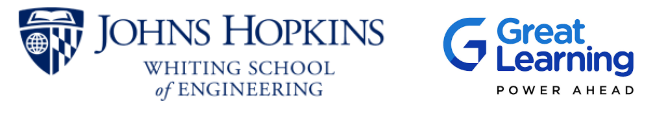

<font size=6>**Advanced RAG**</font>

<font size=5>**Multi-Modal RAG for Healthcare**</font>

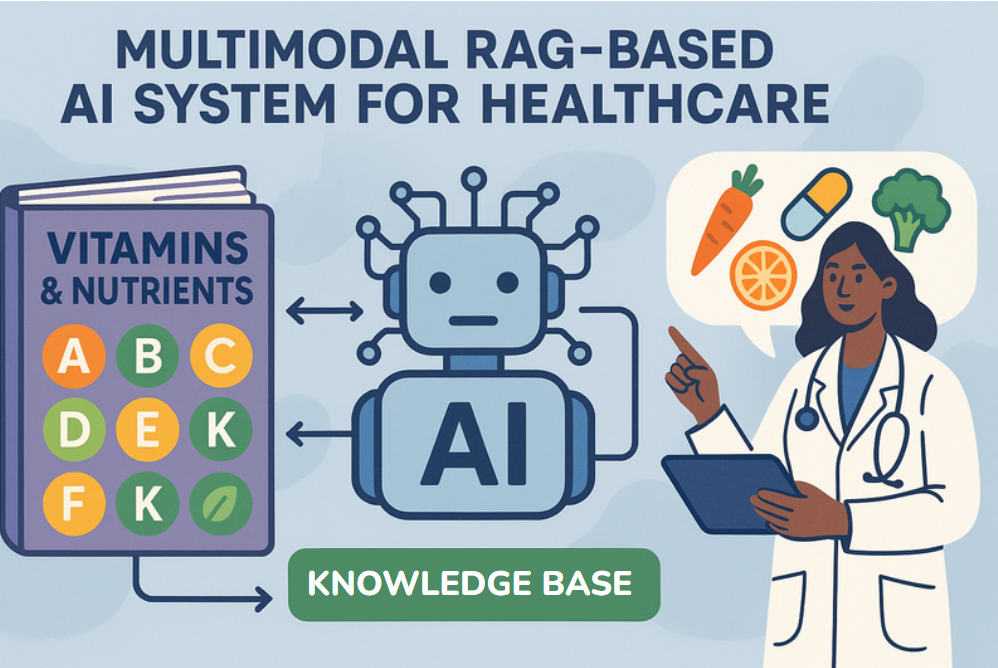

NutriWise is a small-scale Healthcare startup with a mission to spread knowledge and raise awareness about the essential vitamins and nutrients required for optimal human health. Recognizing the growing demand for personalized wellness solutions in today’s digital age, the company offers a variety of premium services, including personalized nutrition consultations and tailored diet plans. With the vision to leave a significant mark in the health and wellness sector, the leadership team brainstormed innovative ways to attract and engage potential customers.

During one of their board meetings, they conceived a groundbreaking idea: to launch a demo version of their services through an AI-powered system, which would be offered to users for free. This approach aims to convert these users into loyal customers who would eventually transition to their premium offerings.

The conceptualized AI system would enable users to ask questions regarding nutrition and health. Instead of consulting with a human nutritionist or dietitian, users could engage with the AI, which would generate tailored responses based on their queries. To enhance user experience, the AI would also provide relevant images that support the responses.

**Solution Approach**

The core of the solution involves the creation of an AI-based Advanced Retrieval-Augmented Generation (RAG) System that encompasses the following key components:

1. **Development of a Text and Image-Based Knowledge Base:** This will compile comprehensive information about vitamins and nutrients, supplemented with relevant images to enrich user understanding.
2. **Implementation of Reranking Methodology:** This process will refine the AI system’s ability to recommend the most relevant responses to user queries, thereby enhancing accuracy and user satisfaction.
3. **Query Expansion Techniques:** These will improve the AI’s comprehension of user queries, making it more efficient in providing precise information tailored to individual needs.

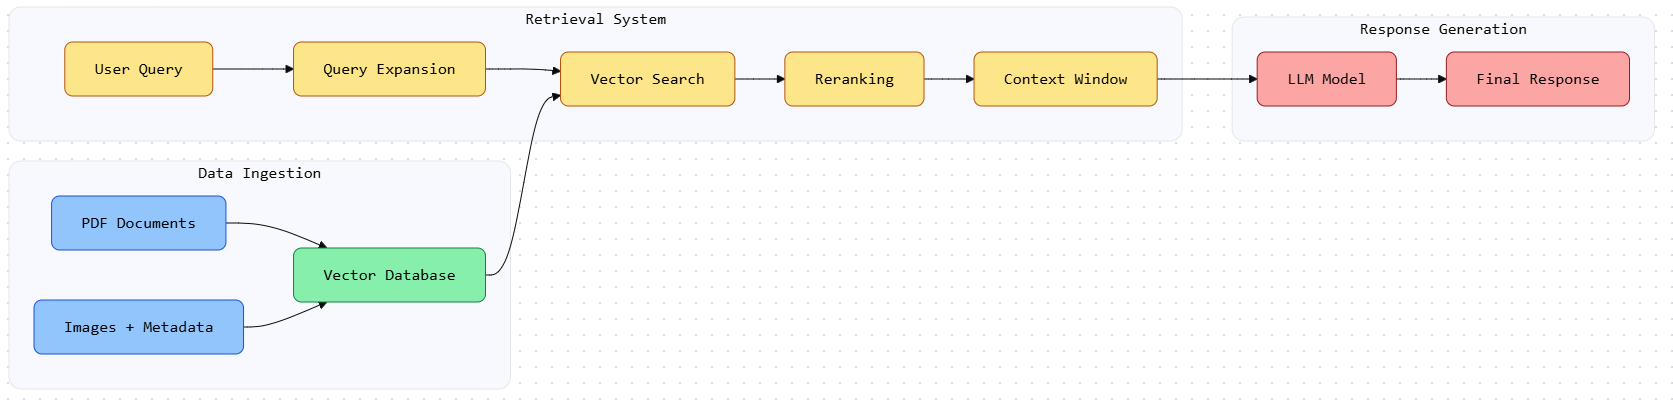

## **Setup**

In [1]:
# @title Run this cell => Restart the session => Start executing the below cells **(DO NOT EXECUTE THIS CELL AGAIN)**

!pip install -q langchain==0.3.21 \
                huggingface_hub==0.29.3 \
                openai==1.68.2 \
                chromadb==0.6.3 \
                langchain-community==0.3.20 \
                langchain_openai==0.3.10 \
                lark==1.2.2\
                rank_bm25==0.2.2\
                numpy==2.2.4 \
                scipy==1.15.2 \
                scikit-learn==1.6.1 \
                transformers==4.50.0 \
                pypdf==5.4.0 \
                markdown-pdf==1.7 \
                sentence_transformers==4.0.0 \
                torch==2.6.0+cu124


%pip install --upgrade chromadb
%pip install pillow
%pip install open-clip-torch
%pip install matplotlib

In [2]:
# Unzipping the Research Papers
import zipfile
with zipfile.ZipFile("/content/MLS14 - Adv RAG.zip", 'r') as zip_ref:
  zip_ref.extractall("/content/")

In [3]:
# @title Loading the `config.json` file
import json
import os

# Load the JSON file and extract values
file_name = 'config.json'
with open(file_name, 'r') as file:
    config = json.load(file)
    os.environ['OPENAI_API_KEY'] = config.get("API_KEY") # Loading the API Key
    os.environ["OPENAI_BASE_URL"] = config.get("OPENAI_API_BASE") # Loading the API Base Url

In [4]:
# @title Defining the Embedding Model - Using `text-embedding-ada-002` Model
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

In [5]:
# @title Defining the LLM Model - Using `gpt-4o-mini` Model
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## **Step 1 : Loading the PDF and storing it in the vectorDB**


In [6]:
from langchain.document_loaders import PyPDFLoader

# Reading the NOFO Document
pdf_file = "/content/MLS14 - Adv RAG/Vitamin_and_minerals.pdf"
pdf_loader = PyPDFLoader(pdf_file);
text_data = pdf_loader.load()

In [7]:
from langchain.vectorstores import Chroma

text_vectorstore = Chroma(
    collection_name="vitamin_and_minerals",
    embedding_function=embeddings)

text_vectorstore.add_documents(documents=text_data)

<ipython-input-7-7f6c7a0bc8bd>:3: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  text_vectorstore = Chroma(


['68683d8b-4aa7-488b-9adb-f03b236482c4',
 'a1684ced-bfee-4dbc-aea7-100e8d3b5f4b',
 '19c412c7-f3d5-445c-8b27-49ae72e7b8a4',
 '42bd58ce-4a96-47cc-83c9-ec760ce1f4dd',
 'fb432287-3765-4c4b-9c3d-99ec3f392656',
 '3e1b4ef1-53ec-44ef-985d-93e2b75a4c25',
 'a4dd4732-1cfc-42de-b362-ffeab840d622',
 '25e2bf4c-ad3a-4eef-9a52-1a6d0dcdb09a',
 'df297903-e962-4a84-93c5-77c3c98a4de3',
 '2ba39e0d-d1f7-4898-a410-b22f07b01b9a',
 '1b8ee592-c746-4911-baeb-49d40d9b7a9e',
 '89db0c9f-02c9-4f33-acd4-748fad1ecaff',
 'e77766e5-5216-4965-92c1-550239c6ca0d',
 'fda2601c-eac9-4dc0-904c-2f37eb8e739e',
 '59df58e4-d4b2-44dd-aad8-595b4984c71d',
 '64fec0f4-a7d7-4176-8d86-4df61d6c08fd',
 'fb9a3656-c04e-4262-bb42-fe5eef5716dc',
 'bcda6637-9664-4285-b195-e4931c165816',
 'f8a63387-f9cd-48af-b231-9614d4608cd6',
 'cfdeb541-9361-45d7-839b-b1e8e5d6cc9e',
 'a15d0dbe-9258-4716-a1e3-ebf166ed7889',
 'f9b03942-231c-475b-8600-9100c36c259b',
 '05d1020a-bd54-4c0d-8f39-284a0738fff5',
 '066dcd33-7955-46c0-ae17-d89fa6b47bee',
 '1c56b51c-1024-

In [8]:
vanilla_retriever = text_vectorstore.as_retriever(search_kwargs={"k": 10})

## **Step 2 : Loading the Images along with metadata and storing them in the vectorDB**

In [9]:
import chromadb
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader
from matplotlib import pyplot as plt
import os

In [10]:
# Create database file at folder "my_vectordb" or load into client if exists
chroma_client = chromadb.PersistentClient(path="my_vectordb")

# Instantiate image loader helper
image_loader = ImageLoader()

# Instantiate multimodal embedding function
image_embedding_function = OpenCLIPEmbeddingFunction()

# Create the collection, aka vector database. Or, if database already exist, then use it. Specify the model that we want to use to do the embedding
multimodal_db = chroma_client.get_or_create_collection(name="multimodal_db", embedding_function=image_embedding_function, data_loader=image_loader)

In [11]:
multimodal_db.count()

11

In [12]:
from PIL import Image
import numpy as np

image_paths = [f"/content/MLS14 - Adv RAG/sources/{file}" for file in os.listdir("/content/MLS14 - Adv RAG/sources")]
image_paths

['/content/MLS14 - Adv RAG/sources/VitaminA-4.png',
 '/content/MLS14 - Adv RAG/sources/VitaminA-3.png',
 '/content/MLS14 - Adv RAG/sources/VitaminA-5.png',
 '/content/MLS14 - Adv RAG/sources/VitaminD-2.png',
 '/content/MLS14 - Adv RAG/sources/VitaminA-1.png',
 '/content/MLS14 - Adv RAG/sources/VitaminC-3.png',
 '/content/MLS14 - Adv RAG/sources/VitaminC-2.png',
 '/content/MLS14 - Adv RAG/sources/VitaminD-3.png',
 '/content/MLS14 - Adv RAG/sources/VitaminC-1.png',
 '/content/MLS14 - Adv RAG/sources/VitaminA-2.png',
 '/content/MLS14 - Adv RAG/sources/VitaminD-1.png']

In [13]:
# Defining Metadata
Metadata = []
for file in os.listdir("/content/MLS14 - Adv RAG/sources"):
  Metadata.append({'Vitamin':file.split("-")[0][-1],
                   'info': f'The images shows the sources of Vitamin {file.split("-")[0][-1]}'})

Metadata

[{'Vitamin': 'A', 'info': 'The images shows the sources of Vitamin A'},
 {'Vitamin': 'A', 'info': 'The images shows the sources of Vitamin A'},
 {'Vitamin': 'A', 'info': 'The images shows the sources of Vitamin A'},
 {'Vitamin': 'D', 'info': 'The images shows the sources of Vitamin D'},
 {'Vitamin': 'A', 'info': 'The images shows the sources of Vitamin A'},
 {'Vitamin': 'C', 'info': 'The images shows the sources of Vitamin C'},
 {'Vitamin': 'C', 'info': 'The images shows the sources of Vitamin C'},
 {'Vitamin': 'D', 'info': 'The images shows the sources of Vitamin D'},
 {'Vitamin': 'C', 'info': 'The images shows the sources of Vitamin C'},
 {'Vitamin': 'A', 'info': 'The images shows the sources of Vitamin A'},
 {'Vitamin': 'D', 'info': 'The images shows the sources of Vitamin D'}]

In [14]:
# Use .add() to add a new record or .update() to update existing record
multimodal_db.add(
    ids=[str(x) for x in range(len(os.listdir("/content/MLS14 - Adv RAG/sources")))],
    uris = image_paths,
    metadatas=Metadata
)

In [15]:
multimodal_db.count()

11

In [16]:
# Simple function to print the results of a query.
# The 'results' is a dict {ids, distances, data, ...}
# Each item in the dict is a 2d list.
def print_query_results(query_list: list, query_results: dict)->None:
    result_count = len(query_results['ids'][0])

    for i in range(len(query_list)):
        for j in range(result_count):
            id       = query_results["ids"][i][j]
            distance = query_results['distances'][i][j]
            data     = query_results['data'][i][j]
            document = query_results['documents'][i][j]
            metadata = query_results['metadatas'][i][j]
            uri      = query_results['uris'][i][j]

            print(f'id: {id}, distance: {distance}, metadata: {metadata}, document: {document}')

            # Display image, the physical file must exist at URI.
            # (ImageLoader loads the image from file)
            print(f'data: {uri}')
            plt.imshow(data)
            plt.axis("off")
            plt.show()

In [17]:
def get_image(query_texts):
# Query vector db
    query_results = multimodal_db.query(
        query_texts = query_texts,
        n_results=2,
        include=['documents', 'distances', 'metadatas', 'data', 'uris'],
    )

    print_query_results(query_texts, query_results)

id: 8, distance: 1.4199872016906738, metadata: {'Vitamin': 'C', 'info': 'The images shows the sources of Vitamin C'}, document: None
data: /content/MLS14 - Adv RAG/sources/VitaminC-1.png


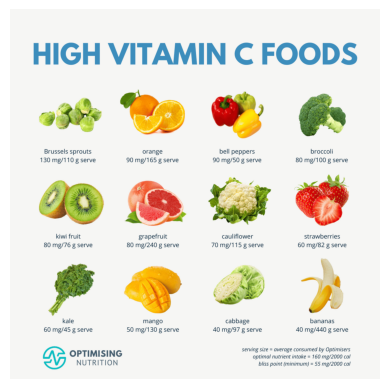

id: 6, distance: 1.4271094799041748, metadata: {'Vitamin': 'C', 'info': 'The images shows the sources of Vitamin C'}, document: None
data: /content/MLS14 - Adv RAG/sources/VitaminC-2.png


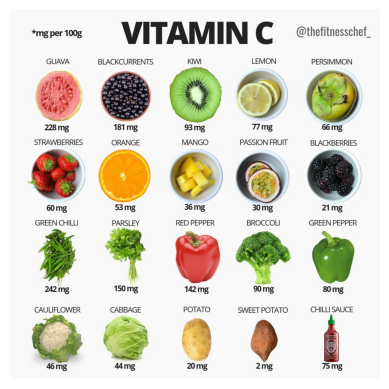

In [18]:
get_image(['Citrus fruits have which common vitamins'])

## **Reranking**

In [19]:
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
crossencoder = HuggingFaceCrossEncoder(model_name="cross-encoder/ms-marco-MiniLM-L-6-v2")

In [20]:
from langchain.retrievers.document_compressors import CrossEncoderReranker
reranker = CrossEncoderReranker(model=crossencoder, top_n=5)

In [21]:
from langchain.retrievers import ContextualCompressionRetriever
reranker_retriever = ContextualCompressionRetriever(
    base_compressor=reranker, base_retriever=vanilla_retriever
)

## **User Query Expansion**

In [22]:
# Query Expansion for User_query

def query_expansion(user_query):
    query_enhancement = f"""
    You are an expert in information retrieval systems, particularly skilled in enhancing queries for document search efficiency.
    Perform query expansion on the received question by considering alternative phrasings or synonyms commonly used in document retrieval contexts.
    If there are multiple ways to phrase the user's question or common synonyms for key terms, provide several reworded versions.

    If there are acronyms or words you are not familiar with, do not try to rephrase them.

    Return at least 3 versions of the question as a list.
    Generate only a list of questions. Do not mention anything before or after the list.

    Question:
    {user_query}
    """


    new_question = llm.invoke(query_enhancement)
    return (new_question.content)

## **Step 3 : Retriever which can fetch the data from (PDF + Images) and return this to the user**

In [23]:
user_query = "What are the benefits of vitamin C & vitamin A"

In [24]:
# Query Expansion
multipule_queries = query_expansion(user_query)
print(multipule_queries)

1. What are the advantages of vitamin C and vitamin A?
2. What are the health benefits associated with vitamin C and vitamin A?
3. How does vitamin C and vitamin A contribute to health?


In [25]:
# Calling the vanilla retriever
vanilla_responses = vanilla_retriever.get_relevant_documents(multipule_queries)

# We can see the results are not sorted
context_query_pairs_for_scoring = [[multipule_queries, doc_text.page_content] for doc_text in vanilla_responses]
crossencoder.score(context_query_pairs_for_scoring)

<ipython-input-25-1d1b32e7825c>:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  vanilla_responses = vanilla_retriever.get_relevant_documents(multipule_queries)


array([-1.6257144 , -2.7113566 , -6.0177746 , -4.3521633 , -3.7880023 ,
       -5.3330545 , -4.8307    , -1.84045   , -0.81040996, -5.801106  ],
      dtype=float32)

**In the above cell, we can observe that we fetched 10 chunks and they are not sorted. Now, we will be following the re-ranking approach to fetch the 5 most relevant chunks from these 10.**

In [34]:
# Calling the reranking retriever
reranked_responses = reranker_retriever.get_relevant_documents(multipule_queries)

In [35]:
# We can see the results are sorted
context_query_pairs_for_scoring = [[multipule_queries, doc_text.page_content] for doc_text in reranked_responses]
crossencoder.score(context_query_pairs_for_scoring)

array([-0.8104099, -1.6257144, -1.84045  , -2.7113566, -3.788    ],
      dtype=float32)

In [36]:
prompt = f"""
You are an expert AI assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.

### Context:
{reranked_responses}

### Question:
{multipule_queries}
"""

In [37]:
llm_response = llm.invoke(prompt)

Answer: 
 ### Advantages and Health Benefits of Vitamin C and Vitamin A

1. **Advantages of Vitamin C:**
   - **Antioxidant Properties:** Vitamin C acts as an electron donor, functioning as a reducing agent and antioxidant, which helps protect cells from oxidative stress.
   - **Enzymatic Functions:** It is essential for the activity of several enzymes involved in collagen synthesis, carnitine biosynthesis, and the metabolism of certain neurotransmitters.
   - **Immune Function:** Vitamin C is known to enhance immune function, potentially reducing the duration and severity of infections.

2. **Advantages of Vitamin A:**
   - **Visual Health:** Vitamin A is crucial for the normal functioning of the visual system, particularly in low-light conditions.
   - **Cellular Integrity:** It plays a vital role in maintaining the integrity of epithelial cells, which are essential for skin and mucosal health.
   - **Growth and Development:** Vitamin A is important for growth and development, partic

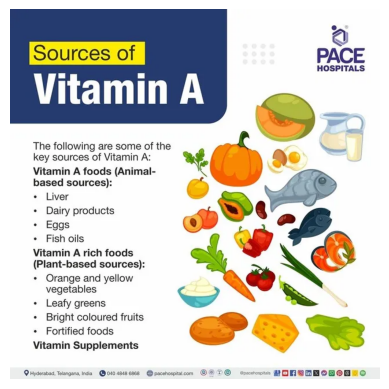

id: 8, distance: 1.3986576795578003, metadata: {'Vitamin': 'C', 'info': 'The images shows the sources of Vitamin C'}, document: None
data: /content/MLS14 - Adv RAG/sources/VitaminC-1.png


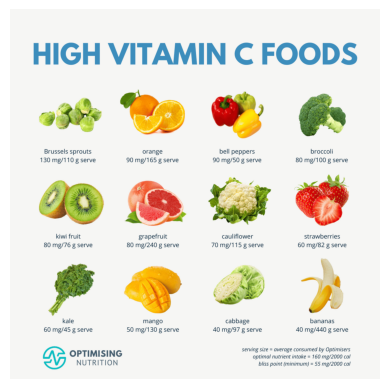

In [38]:
print("Answer: \n", llm_response.content)
print("="*50)
print("Relevant Images: \n")
get_image([llm_response.content])

**Note :** To improve the accuracy of retrieving relevant images, it's important to increase the number of images in the database the more images available, the better the system can identify and return relevant results.

## **Further Enhancement**
> Deploy the same application on the Gradio

In [32]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 106.1 MB/s eta 0:00:00


In [48]:
import gradio as gr

def predict(user_query):

    # Query Expansion
    multipule_queries = query_expansion(user_query)

    # Reranking
    reranked_responses = reranker_retriever.get_relevant_documents(multipule_queries)

    prompt = f"""
    You are an expert AI assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the question.

    ### Context:
    {reranked_responses}

    ### Question:
    {multipule_queries}
    """

    # Fetching Text
    llm_response = llm.invoke(prompt)

    # Fetching Images
    rel_img = multimodal_db.query(
        query_texts = llm_response.content,
        n_results=2,
        include=['uris'],
    )

    return llm_response.content, rel_img['uris'][0] # Return both text and image paths


iface = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(label="Enter your query"),
    outputs=[gr.Markdown(label= "Answer"), gr.Gallery(label="Relevant Images")],  # Using Gallery for images
    title="NutriWise AI Assistant",
    description="Ask questions about nutrition and health"
)

iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8d77e3d1f6b0e318db.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
